# Lennard-Jones Potentials for modelling phase transitions in materials

Nested Sampling is the ideal tool for computing the partition function.

$$Z(\beta) = \int_\mathcal{X} e^{-\beta E(x)} \, \mathrm{d}x$$

where $\beta \in [0, \infty)$ is the inverse temperature parameter, $\mathcal{X}$ is the set of all configurations of the system, and $E : \mathcal{X} \to \mathbb{R}$ is the potential function, which in this case will be the Lennard-Jones potential,

$$E(x) = 4 \epsilon \sum_{i,j} \left( \left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6 \right).$$

In this equation, the $-\epsilon$ represents the energy of the ground state, and $\sigma$ is the equilibrium distance when the potential energy is zero.

The system is invariant to changes in sigma and the total size of the region. Therefore, we choose $\sigma$ as a ratio with the size of the box. We'll chose to sample states within a unit box, therefore, we are choosing how big the box is in units of $\sigma$. Choosing $\sigma=0.01$ is equivalent to choosing, means the volume is roughly 100 particles per side.

In [1]:

import jax

jax.config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:

def pairwise_distances_squared(points):
    n = points.shape[0]
    pair_indices = jnp.triu_indices(n, 1)  # Upper triangular indices, excluding diagonal

    # Create function that calculates the distance between two points
    def dist_fn(ij):
        i, j = ij
        return jnp.sum(jnp.square(points[i] - points[j]))

    # Apply this function to each pair of indices
    pairwise_distances = vmap(dist_fn)(pair_indices)

    return pairwise_distances


# test pairwise_distances_squared
points = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
assert jnp.all(pairwise_distances_squared(points) == jnp.asarray([8, 32, 72, 8, 32, 8]))

In [3]:


from jaxns.internals.log_semiring import LogSpace
import jaxns.framework.context as ctx

num_particles = 4
num_pairs = num_particles * (num_particles - 1) // 2
sigma = jnp.asarray(0.439)
epsilon = jnp.asarray(1.)
box_length = jnp.asarray(4.)


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros((num_particles, 3)), high=box_length * jnp.ones((num_particles, 3))),
                    name='x')
    beta = ctx.get_parameter('beta', init=jnp.asarray(1.))
    return x, beta


def log_likelihood(x, beta):
    """
    negative V12-6 potential. Epsilon=1, beta=1.
    """
    r2_ij = LogSpace(jnp.log(pairwise_distances_squared(x / sigma)))

    r6_ij = r2_ij ** 3
    r12_ij = r6_ij ** 2
    r6_ij_inv = r6_ij ** -1
    r12_ij_inv = r12_ij ** -1
    E = LogSpace(jnp.log(4. * epsilon)) * (r12_ij_inv - r6_ij_inv)
    E = E.sum().value
    return -beta * E


model = Model(
    prior_model=prior_model,
    log_likelihood=log_likelihood
)
params = model.params

print(params)

model.sanity_check(random.PRNGKey(42), 1000)


{'beta': Array(1., dtype=float64, weak_type=True)}


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [4]:
import jax
from jaxns import DefaultNestedSampler, TerminationCondition

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(
    model=model,
    max_samples=1e6,
    s=model.U_ndims * 10,
    k=0,
    c=model.U_ndims * 10
)

# Crucial for Lenard-Jones potential is to go deep enough. 
# Since we know min(E)=-epsilon for a single pair, we know that the log_L_max = epsilon * num_pairs 
# Thus we can use the log_L_contour termination condition.
term_cond = TerminationCondition(
    log_L_contour=0.995 * epsilon * num_pairs,
    dlogZ=0.
)
ns_compiled = jax.jit(ns).lower(jax.random.PRNGKey(42), term_cond=term_cond).compile()

termination_reason, state = ns_compiled(random.PRNGKey(42), term_cond=term_cond)

results = ns.to_results(
    termination_reason=termination_reason,
    state=state,
    trim=True
)

ns.summary(results)

--------
Termination Conditions:
Likelihood contour reached
--------
likelihood evals: 22996757
samples: 4200
phantom samples: 0
likelihood evals / sample: 5475.4
phantom fraction (%): 0.0%
--------
logZ=0.021 +- 0.027
max(logL)=5.992
H=-0.1
ESS=143
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 1.9 +- 1.1 | 0.3 / 1.9 / 3.4 | 0.6 | 0.6
x[1]: 2.2 +- 1.1 | 0.8 / 2.2 / 3.6 | 0.6 | 0.6
x[2]: 2.0 +- 1.1 | 0.6 / 1.9 / 3.4 | 2.1 | 2.1
x[3]: 2.0 +- 1.2 | 0.4 / 2.2 / 3.6 | 0.4 | 0.4
x[4]: 1.8 +- 1.1 | 0.3 / 1.8 / 3.3 | 0.2 | 0.2
x[5]: 2.1 +- 1.1 | 0.5 / 2.1 / 3.6 | 2.1 | 2.1
x[6]: 1.9 +- 1.0 | 0.5 / 1.9 / 3.2 | 0.1 | 0.1
x[7]: 2.0 +- 1.1 | 0.5 / 2.0 / 3.6 | 0.6 | 0.6
x[8]: 1.9 +- 1.2 | 0.3 / 1.9 / 3.5 | 2.3 | 2.3
x[9]: 2.1 +- 1.1 | 0.5 / 2.1 / 3.7 | 0.2 | 0.2
x[10]: 1.9 +- 1.2 | 0.3 / 2.0 / 3.5 | 0.5 | 0.5
x[11]: 1.9 +- 1.2 | 0.3 / 1.9 / 3.5 | 1.8 | 1.8
--------


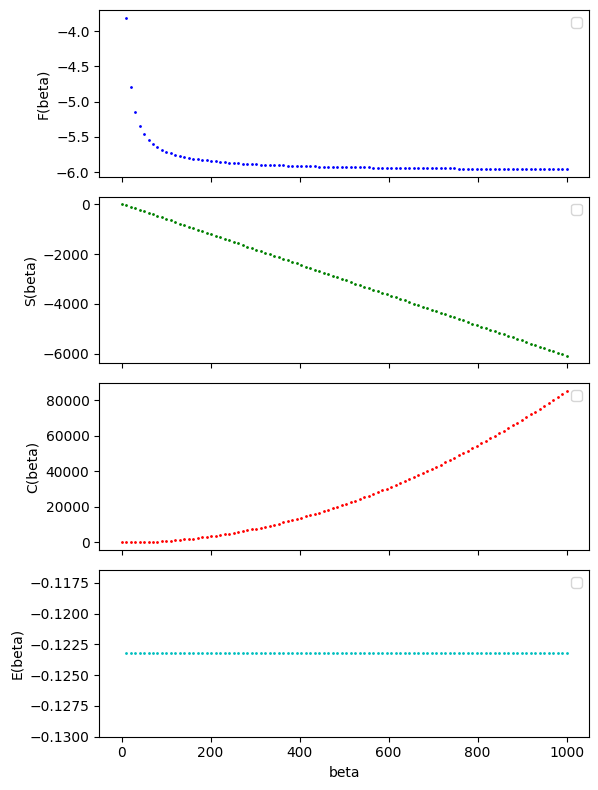

In [5]:
from typing import NamedTuple

quantity_names = ['F(beta)', 'S(beta)', 'C(beta)', 'E(beta)']
colors = ['b', 'g', 'r', 'c']


class Quantities(NamedTuple):
    F: jax.Array
    S: jax.Array
    C: jax.Array
    E: jax.Array


class IntermediateQuantities(NamedTuple):
    beta_E: jax.Array
    beta_E2: jax.Array


def compute_integrands_of_interest(model, U) -> IntermediateQuantities:
    beta_E = -model.forward(U)  # E(x)
    beta_E2 = beta_E ** 2
    return IntermediateQuantities(beta_E=beta_E, beta_E2=beta_E2)


@jax.jit
def compute_quantities(beta) -> Quantities:
    integrands = jax.vmap(
        lambda U: compute_integrands_of_interest(model({'beta': beta}), U)
    )(results.U_samples)
    weights = LogSpace(results.log_dp_mean)
    # Z(beta) = int exp(-beta E(x)) dx
    Z_beta = (LogSpace(-integrands.beta_E) * weights).sum()
    F_beta = -Z_beta.log_abs_val / beta
    exp_beta_E = (LogSpace.from_signed_value(integrands.beta_E) * weights).sum()
    exp_beta_E2 = (LogSpace.from_signed_value(integrands.beta_E2) * weights).sum()
    S_beta = (exp_beta_E - Z_beta.log()).value
    C_beta = (exp_beta_E2 - exp_beta_E ** 2).value
    E_beta = (exp_beta_E / LogSpace(jnp.log(beta))).value
    return Quantities(
        F=F_beta,
        S=S_beta,
        C=C_beta,
        E=E_beta
    )


x = []
y = []
import pylab as plt

fig, axs = plt.subplots(len(quantity_names), 1, figsize=(6, len(quantity_names) * 2), squeeze=False, sharex=True)
for beta in jnp.linspace(0., 1000, 100):
    quantities = compute_quantities(beta)
    x.append(beta)
    y.append(quantities)
    for i, (name, q, c) in enumerate(zip(quantity_names, quantities, colors)):
        axs[i, 0].scatter(beta, q, color=c, s=1)

for i, (name, c) in enumerate(zip(quantity_names, colors)):
    axs[i, 0].set_ylabel(name)
    # Only 1 label on legend, despite labelling each beta
    axs[i, 0].legend()
axs[-1, 0].set_xlabel('beta')
plt.tight_layout()
plt.show()

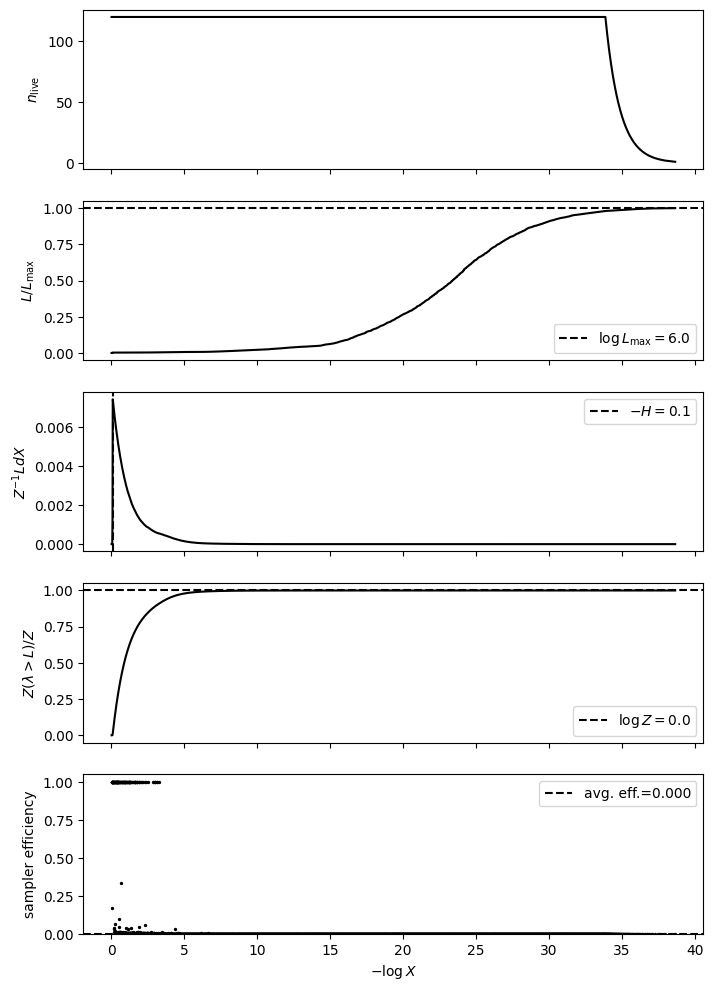

In [6]:
ns.plot_diagnostics(results)

In [7]:
ns.save_results(results, 'results.json')